In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, dataset, random_split
import torchvision
from torchvision import datasets, models, transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import itertools
import collections

from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow

from PIL import ImageFile
from PIL import Image

from scipy.ndimage.filters import median_filter


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def normalize(image):
    norm = ((image-image.min())/(image.max()-image.min()))
    return norm

def merge_bands(band1, band2):
    b1 = np.array(band1).astype(np.float32).reshape(75,75)
    b2 = np.array(band2).astype(np.float32).reshape(75,75)
    b1 = np.array([normalize(x) for x in b1])
    b2 = np.array([normalize(x) for x in b1])
    return [np.dstack((b1,b2))]

In [ ]:
def load_data(path,is_train):
  df = pd.read_json(path, dtype={'inc_angle': 'str'}).set_index('id')
  df['inc_angle'] = df.inc_angle.replace('na', '0.0')
  df['fake'] = df.inc_angle.apply(lambda x: len(x.split('.')[1]) > 5)
  df['inc_angle'] = df.inc_angle.astype('float64')      
  df['train'] = is_train
  return df



In [ ]:
def auto_canny(image, sigma=0.7):
	v = np.median(image)
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edge = cv2.Canny(image, lower, upper)
  return edge

In [ ]:
train_data = load_data('drive/My Drive/train.json/data/processed/train.json', 1)
test_data = load_data('drive/My Drive/test.json/data/processed/test.json', 0)



In [ ]:
class MyDataset(Dataset):

    def __init__(self,df, transform, transform_edge):
      self.df = df
      self.transform_edge = transform_edge
      self.transform = transform

    def __len__(self):
      return len(self.df)

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
        idx = idx.tolist()

      band_1 = self.df['band_1'].values[idx]
      band_1 = np.array(band_1).astype(np.float32).reshape(75,75)
      band_1 = normalize(band_1)
      band_1 = (band_1*255).astype(np.uint8)
      band_1 = median_filter(band_1, 6)

      band_2 = self.df['band_2'].values[idx]
      band_2 = np.array(band_2).astype(np.float32).reshape(75,75)
      band_2 = normalize(band_2)
      band_2 = (band_2*255).astype(np.uint8)
      band_2 = median_filter(band_2, 6)

      edges_1= auto_canny(band_1)
      edges_2= auto_canny(band_2)

      if self.transform:
        band_1 = self.transform(band_1)
        band_2 = self.transform(band_2)
        
      if self.transform_edge:
        edges_1 = self.transform_edge(edges_1)
        edges_2 = self.transform_edge(edges_2)

      edges_1 = edges_1.T
      edges_2 = edges_2.T

      stacked_edge = np.dstack((edges_1,edges_2))
     
      band_1 = band_1.T
      band_2 = band_2.T

      stacked_normal = np.dstack((band_1,band_2))
     
      label = self.df['is_iceberg'].values[idx]

      sample = {'normal': stacked_normal.T, 'edge': stacked_edge.T, 'classes': label}
      
      return  sample

In [ ]:
transform_edge = transforms.Compose([
  transforms.ToPILImage(),
  transforms.ToTensor(),                             
])

In [ ]:
transform = transforms.Compose([
  transforms.ToPILImage(),
  transforms.ToTensor(),                             
])

In [ ]:
def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),horizontalalignment="center",color="white" if cm[i, j] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def getdataloader_sizes(batchsize): 
  dataset =  MyDataset(df = train_data, transform = transform, transform_edge = transform_edge)


  train_size = int(0.8 * len(dataset))
  val_size = int((len(dataset) - train_size) / 2)
  test_size = len(dataset) - train_size - val_size
  print(len(dataset))

  train, validation, test = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
  all_datasets = {'train' : train, 'validation' : validation, 'test' : test}

  dataloaders = {x: torch.utils.data.DataLoader(all_datasets[x], batch_size=batchsize,
                                               shuffle=True, num_workers = 8)
                for x in ['train', 'validation' ,'test']}
  dataset_sizes = {x: len(all_datasets[x]) for x in ['train', 'validation','test']}

  class_names = ["is_iceberg", "is_ship"]
  return dataloaders,dataset_sizes,class_names


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [ ]:
def plot_graph(plotlist1,plotlist2,ylabel):
    plt.xlabel("Training Epochs")
    plt.ylabel(ylabel)
    plt.plot(plotlist1, color="green")
    plt.plot(plotlist2, color="yellow")
    plt.gca().legend(('Train', 'Validation'))
    plt.show()

In [ ]:
def train_model(model, criterion, optimizer, epoch_number,device,earlystopping):
   
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_train_acc = 0.0
    best_val_acc = 0.0
    best_test_acc = 0.0
    train_acc_history = list()
    train_loss_history =list()
    val_acc_history = list()
    val_loss_history =list()
    
    counter = 0
    stop =False
    best_loss = None
    
   
    n_epochs_stop = 1
    min_val_loss = np.Inf
    epochs_no_improve = 0
    
    for epoch in range(epoch_number):
        if stop:
          break
        print('Epoch {}/{}'.format(epoch, epoch_number - 1))
        
        # Train and validation for each epoch
        for part in ['train', 'validation']:
            if part == 'train':
                
                model.train()  
            else:
                model.eval()  

            current_loss = 0.0
            current_phase_correct_outputnumber = 0
            # For each phase in datasets are iterated
            for i, data in enumerate(dataloaders[part], 0):

                input_N, input_E, labels = data['normal'], data['edge'], data['classes']
                input_N = input_N.to(device)
                input_E = input_E.to(device)
                labels = labels.to(device)
               
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                with torch.set_grad_enabled(part == 'train'):
                    outputs = model(input_N, input_E)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # Backpropagate and opitimize Training part
                    if part == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                current_loss += loss.item() * input_N.size(0)
                current_phase_correct_outputnumber += torch.sum(preds == labels.data)

            current_loss = current_loss / dataset_sizes[part]
            epoch_acc = 100*current_phase_correct_outputnumber.double() / dataset_sizes[part]

            if part == 'validation':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(current_loss)
                if earlystopping:
                  # If the validation loss is at a minimum
                  if current_loss < min_val_loss:
                    # Save the model
                    epochs_no_improve = 0
                    min_val_loss = current_loss

                  else:
                    epochs_no_improve += 1
                    # Check early stopping condition
                    if epochs_no_improve == n_epochs_stop:
                      print('Early stopping!')
                      
                      #Printed best accuracies
                      print('Best train Acc: {:4f}'.format(best_train_acc))
                      print('Best validation Acc: {:4f}'.format(best_val_acc))

                      print()

                      #Printed best accuracies
                      print('Best train Acc: {:4f}'.format(best_train_acc))
                      print('Best validation Acc: {:4f}'.format(best_val_acc))

                      # load best model weights
                      model.load_state_dict(best_model_wts)
                      #Plot accuracy graph 
                      plot_graph(train_acc_history,val_acc_history,"Accuracy")
                      plot_graph(train_loss_history,val_loss_history,"Loss")
                      
                      return model                  
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(current_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                part, current_loss, epoch_acc))

            # deep copy the model
            if part == 'train' and epoch_acc > best_train_acc:
                  best_train_acc = epoch_acc
                
            if part == 'validation' and epoch_acc > best_val_acc:             
                best_val_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
              
        print() 
    
              
    print('Best train Acc: {:4f}'.format(best_train_acc))
    print('Best validation Acc: {:4f}'.format(best_val_acc))
    
  
    model.load_state_dict(best_model_wts)
   
    plot_graph(train_acc_history,val_acc_history,"Accuracy")
    plot_graph(train_loss_history,val_loss_history,"Loss")
  
    return model

In [ ]:
class Edge_Net(nn.Module):

  def __init__(self):
    super(Edge_Net, self).__init__()
    self.conv1 = torch.nn.Conv2d(2, 18, kernel_size = 3, stride = 1, padding = 1)
    self.fc1 = torch.nn.Linear(18 * 75 * 75, 64)
    self.fc2 = torch.nn.Linear(64, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = x.view(-1, 18 * 75 *75)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return(x)

In [ ]:
class Normal_Net(nn.Module):

  def __init__(self):
    super(Normal_Net, self).__init__()

    self.conv1 = torch.nn.Conv2d(2, 18, kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = torch.nn.Conv2d(18, 64, kernel_size = 3, stride = 1, padding = 1)
    self.fc1 = torch.nn.Linear(64 * 75 * 75, 64)
    self.fc2 = torch.nn.Linear(64, 2)

  
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = x.view(-1, 64 * 75 *75)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return(x)

In [ ]:
class EarlyFusionModel(nn.Module):
    def __init__(self, modelA, modelB, nb_classes=2):
        super(EarlyFusionModel, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelA.fc2 = nn.Identity()
        self.modelB.fc2 = nn.Identity()
        self.classifier = nn.Linear(64+64, nb_classes)
        
    def forward(self, x, y):
        x1 = self.modelA(x)
        x1 = x1.view(x1.size(0), -1)

        x2 = self.modelB(y)
        x2 = x2.view(x2.size(0), -1)
        x = torch.cat((x1, x2), dim=1)
        
        x = self.classifier(F.relu(x))
        return x

1604
Epoch 0/199
train Loss: 0.6908 Acc: 53.7023
validation Loss: 0.7014 Acc: 43.7500

Epoch 1/199
train Loss: 0.6889 Acc: 53.7023
validation Loss: 0.7024 Acc: 43.7500

Epoch 2/199
train Loss: 0.6872 Acc: 53.7023
validation Loss: 0.7007 Acc: 43.7500

Epoch 3/199
train Loss: 0.6860 Acc: 53.7023
validation Loss: 0.6916 Acc: 43.1250

Epoch 4/199
train Loss: 0.6847 Acc: 53.1567
validation Loss: 0.6948 Acc: 43.7500

Epoch 5/199
train Loss: 0.6832 Acc: 54.1699
validation Loss: 0.6929 Acc: 43.7500

Epoch 6/199
train Loss: 0.6818 Acc: 53.9361
validation Loss: 0.6860 Acc: 56.8750

Epoch 7/199
train Loss: 0.6805 Acc: 54.7155
validation Loss: 0.6838 Acc: 60.6250

Epoch 8/199
train Loss: 0.6799 Acc: 55.4170
validation Loss: 0.6874 Acc: 48.1250

Epoch 9/199
train Loss: 0.6781 Acc: 53.8581
validation Loss: 0.6884 Acc: 46.2500

Epoch 10/199
train Loss: 0.6767 Acc: 55.2611
validation Loss: 0.6847 Acc: 51.2500

Epoch 11/199
train Loss: 0.6755 Acc: 57.3655
validation Loss: 0.6799 Acc: 60.6250

Epoch 12/

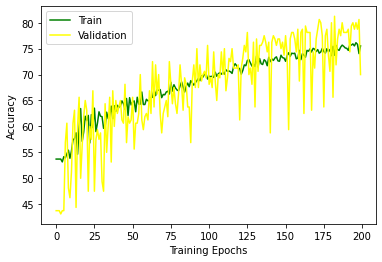

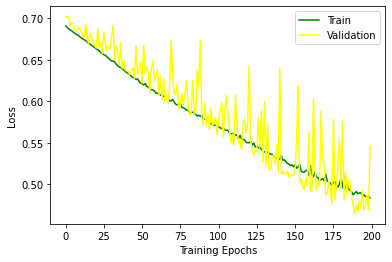

In [ ]:
normal_Net = Normal_Net()
edge_Net = Edge_Net()

trainingmodel = EarlyFusionModel(normal_Net, edge_Net)

#initializing parameters
learning_rate = 0.001
epoch = 200
batchsize = 64
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(trainingmodel.parameters(), lr=learning_rate)
earlystoping = False


dataloaders,dataset_sizes,class_names = getdataloader_sizes(batchsize)

trained_model = train_model(trainingmodel, criterion, optimizer,epoch,device,earlystoping)

In [ ]:
def calculateTestAcc(trained_model,dataloaders,dataset_sizes):
  confusion_matrixx = torch.zeros(2, 2)
  np.set_printoptions(precision=2)
  current_phase_correct_outputnumber = 0

  with torch.no_grad():
    for i, data in enumerate(dataloaders['test']):

        input_N, input_E, classes = data['normal'], data['edge'], data['classes']

        input_N = input_N.to(device)
        input_E = input_E.to(device)
        classes = classes.to(device)

        outputs = trained_model(input_N, input_E)
        _, preds = torch.max(outputs, 1)

        current_phase_correct_outputnumber += torch.sum(preds == classes.data)
          
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrixx[t.long(), p.long()] += 1
   
    test_acc = 100*current_phase_correct_outputnumber.double() / dataset_sizes['test']

    print('Test Acc: {:4f}'.format(test_acc))
    
  plt.figure(figsize = (10,10))
  plot_confusion_matrix(confusion_matrixx,classes=class_names)
  plt.show()

Test Acc: 80.124224


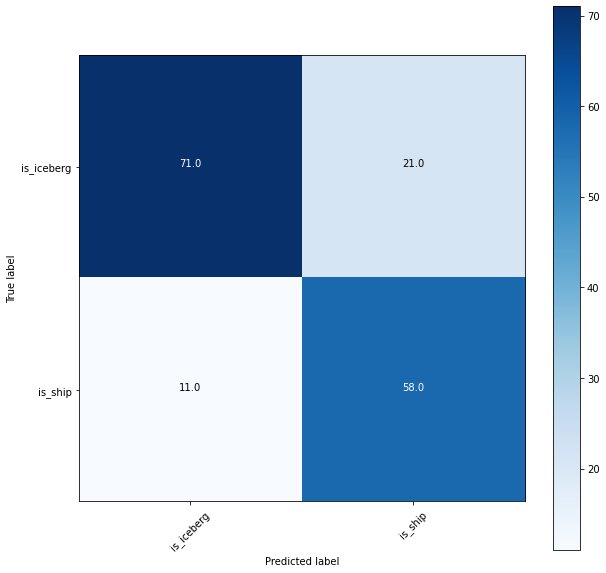

In [ ]:
calculateTestAcc(trained_model,dataloaders,dataset_sizes)